# MNIST-MINI, Extended Results

This notebook has the following structure:

1. Loads the log file from the MNIST-MINI extended experiments
2. Describes the experiment and explore experiment data and metadata
3. Reports comparison between parameter magnitude masks and random masks in terms of their overlap, showing that:
  * parameter magnitude masks have substantially larger overlap than random
  * overlap of randomly drawn masks aligns roughly with the analytical baseline

In [1]:
import collections
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tueplots import bundles, figsizes

In [2]:
# setup and globals
sns.set_theme(style="white")
colors = sns.color_palette()

# Load Experiment Data

In [3]:
def read_file(
    path,
    body_fn=lambda x: x,
    filter_headers=None,
    ts_colname="TIMESTAMP",
    header_colname="HEADER",
):
    """
    Load a log file into a pandas table. The file is assumed to be created
    by repeatedly calling the ``loj`` method, hence having lines in the
    form ``[timestamp, [header, body]]``.

    :param filter_headers: Collection of allowed headers. If given, only
      entries with these headers will be gathered.
    :param body_fn: The ``body`` entry from each line will be passed to
      this function for processing. The function must return a dictionary,
      such that all the returned key-value pairs will be aggregated into
      the output pandas table. If the body is already in the form of a
      dictionary, and you want to preserve all key-value pairs, this
      function is simply the identity. It can be used to filter out
      entries, rename keys, etc.
    :returns: A pandas dataframe, with ``ts_colname, header_colname``
      columns, as well as one column per key returned by ``body_fn``.
    """
    # first gather a list of [timestamp, [header, body]] entries
    entries = pd.read_json(path, lines=True).values.tolist()
    result = []
    for i, (ts, (header, body)) in enumerate(entries):
        if (filter_headers is not None) and (header not in filter_headers):
            continue
        body = body_fn(body)
        assert (ts_colname not in body) and (
            header_colname not in body
        ), "Colliding timestamp/header column names! {body.keys()}"
        try:
            result.append({ts_colname: ts, header_colname: header, **body})
        except TypeError:
            breakpoint()
            pass
    #
    result = pd.DataFrame(result)
    return result


def parse_log_hess(
    log_hess,
    step,
    fields={
        "core_S",
        "info",
        "Frob(H)^2",
        "Frob(H_355)^2",
        "Frob(H_178)^2",
        "Frob(H_18)^2",
        "Frob(H-H_355)^2",
        "Frob(H-H_178)^2",
        "Frob(H-H_18)^2",
        "P(err<=0.75x)",
        "P(err>=1.25x)",
        "P(err<=0.5x)",
        "P(err>=1.5x)",
        "P(err<=0x)",
        "P(err>=2x)",
        "scree_lower",
        "scree_upper",
        "frob_Qtop^2_mag",
        "frob_Qtop^2_best",
        "frob_Qtop^2_rand",
        "largest_absparams",
        "best_overlap_params",
    },
):
    """ """
    result = {}
    for field in fields:
        vals = log_hess[log_hess["step"] == step][field]
        vals = vals[vals.notnull()]
        try:
            vals = vals.item()
        except ValueError:
            pass
        result[field] = vals
    return result

In [4]:
LOG_PATH = "2024_03_27_04_35_53.077[20b_mnist_mini_random_masks.py].log"
#
log_conf = read_file(LOG_PATH, filter_headers={"CONFIG"})
log_glob = read_file(LOG_PATH, filter_headers={"GLOBALS"})
log_batch = read_file(LOG_PATH, filter_headers={"TRAINING BATCH"})
log_eval = read_file(LOG_PATH, filter_headers={"EVAL ROUND", "FINAL EVALUATION"})
log_test_hess = read_file(LOG_PATH, filter_headers={"H_TEST RESULT"})
log_train_hess = read_file(LOG_PATH, filter_headers={"H_TRAIN RESULT"})
#
num_params = int(log_glob["num_params"][0])
record_steps = log_glob["record_steps"].item()
test_hess_data = [parse_log_hess(log_test_hess, step) for step in record_steps]
train_hess_data = [parse_log_hess(log_train_hess, step) for step in record_steps]

# Experiment Summary:

* Trained 7030-parameter MLP on downsampled MNIST digit classification
* Trained for 1000 steps reaching 95.78% accuracy
* Every 100 steps, computed sketched (train/test) Hessian eigendecomposition using 50 samples per class (500 total) and 355 eigenpairs (5% of total)
* Logged several quantities of interest:
  * obtained eigenspectra
  * quality of recovery
  * overlap for parameter magnitude masks, best-overlap masks, and random masks

Below is an overview of the data:

In [5]:
log_conf

,TIMESTAMP,HEADER,OBS_DATASETS,TUNING_CONF,OPTIMIZER,PROBLEM,RANDOM_SEED,MAX_STEPS,DEVICE,OUTPUT_DIR,OUTDIR_SUFFIX,RECORD_STEPS,NUM_HESSIAN_DATAPOINTS,WITH_TEST_HESSIAN,WITH_TRAIN_HESSIAN,NUM_OUTER,NUM_INNER,WITH_A_POSTERIORI,NUM_A_POSTERIORI,NUM_RAND_MASKS
0,2024-03-27_04:35:53.080,CONFIG,REDACTED/datasets/DeepOBS,config/basic_config.yaml,SGD,mnist_mini,12345,16001,cuda,output,20b,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...",500,True,True,355,710,True,30,10


In [6]:

log_glob

,TIMESTAMP,HEADER,run_dir,batch_size,num_epochs,max_steps,steps_per_epoch,opt_name,opt_hpars,sched_name,sched_hpars,param_shapes,num_params,H_train_idxs,H_test_idxs,record_steps
0,2024-03-27_04:35:57.007,GLOBALS,output/2024_03_27_04_35_53.076__mnist_mini__12...,500,50,16001,100,SGD,{'lr': 0.30000000000000004},None,None,"[[20, 256], [20], [20, 20], [20], [20, 20], [2...",7030,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 100, 200, 300, 400, 500, 600, 700, 800, 90..."


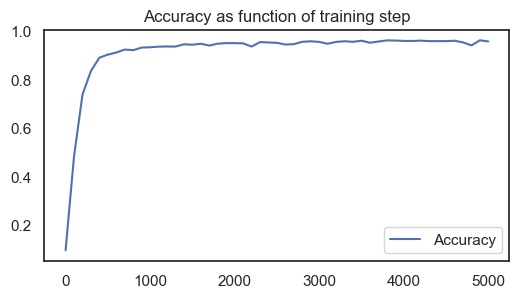

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(log_eval["global_step"], log_eval["test_acc"], label="Accuracy")
ax.legend()
_ = ax.set_title("Accuracy as function of training step")

# Comparing overlap of magnitude masks with random masks

Once the top Hessian eigenbasis is obtained (in the form of a tall matrix), a submatrix $V$ can be obtained by picking $k$ rows will correspond to a parameter mask (since each row corresponds to one parameter). Then, the `overlap` metric can be computed as $\frac{\lVert V \rVert_F^2}{k}$.

In the paper, we computed `overlap` for parameter masks obtained from the $k$-largest parameter magnitudes.
For this extended experiment, we further sampled random columns of $k$ elements, corresponding to random masks, in order to obtain an empirical baseline for overlap.

Comparative results are plotted below. This experiment reinforces the results already reported:

* It can still be observed that magnitude masks yield an overlap that is substantially larger than random
* This random baseline aligns closely with the analytical baseline presented in the paper

In [8]:
def get_overlaps(step, hess_data):
    """
    """
    k_range = np.arange(len(train_hess_data[0]["frob_Qtop^2_mag"])) + 1
    analytical_baseline = k_range / num_params
    mag_overlap = np.array(train_hess_data[0]["frob_Qtop^2_mag"]) / k_range
    rand_overlaps = np.array(train_hess_data[0]["frob_Qtop^2_rand"]) / k_range
    #
    rand_mean = rand_overlaps.mean(axis=0)
    rand_std = rand_overlaps.std(axis=0)
    #
    return mag_overlap, (rand_mean, rand_std)

mag_train0, (rm_train0, rsdt_train0) = get_overlaps(record_steps[0], train_hess_data)
mag_train1, (rm_train1, rsdt_train1) = get_overlaps(record_steps[-1], train_hess_data)
mag_test0, (rm_test0, rsdt_test0) = get_overlaps(record_steps[0], test_hess_data)
mag_test1, (rm_test1, rsdt_test1) = get_overlaps(record_steps[-1], test_hess_data)
analytical_baseline = np.arange(len(mag_train0)) / num_params

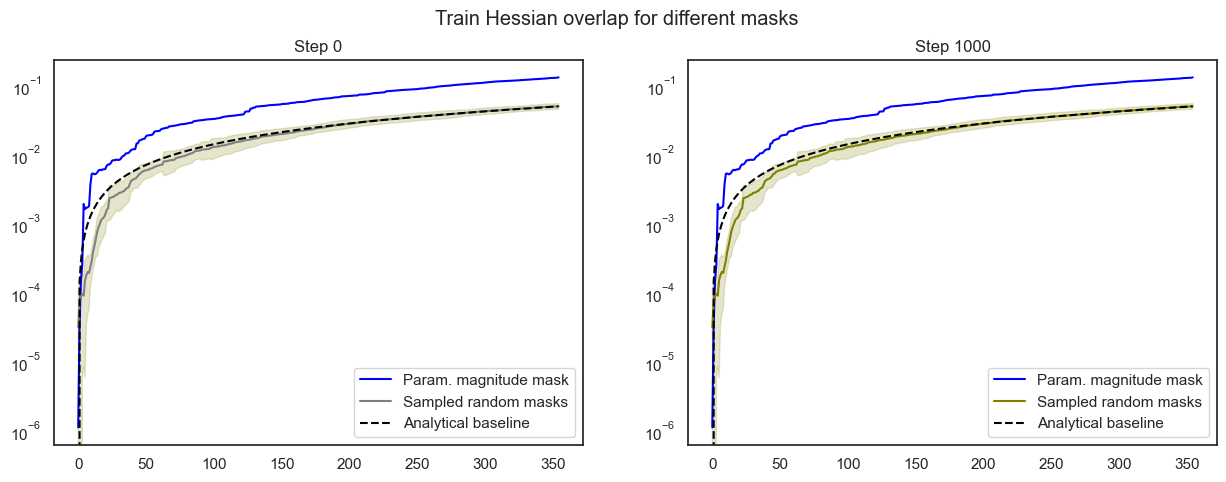

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
#
ax1.plot(mag_train0, color="blue", label="Param. magnitude mask")
ax1.plot(rm_train0, color="gray", label="Sampled random masks")
ax1.fill_between(list(range(len(rm_train0))), rm_train0-rsdt_train0, rm_train0+rsdt_train0, color="olive", alpha=0.2)
ax1.plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline")
ax1.set_yscale("log")
#
ax2.plot(mag_train1, color="blue", label="Param. magnitude mask")
ax2.plot(rm_train1, color="olive", label="Sampled random masks")
ax2.fill_between(list(range(len(rm_train1))), rm_train1-rsdt_train1, rm_train1+rsdt_train1, color="olive", alpha=0.2)
ax2.plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline")
ax2.set_yscale("log")
#
ax1.legend()
ax2.legend()
fig.suptitle("Train Hessian overlap for different masks")
ax1.set_title(f"Step {record_steps[0]}")
_ = ax2.set_title(f"Step {record_steps[-1]}")

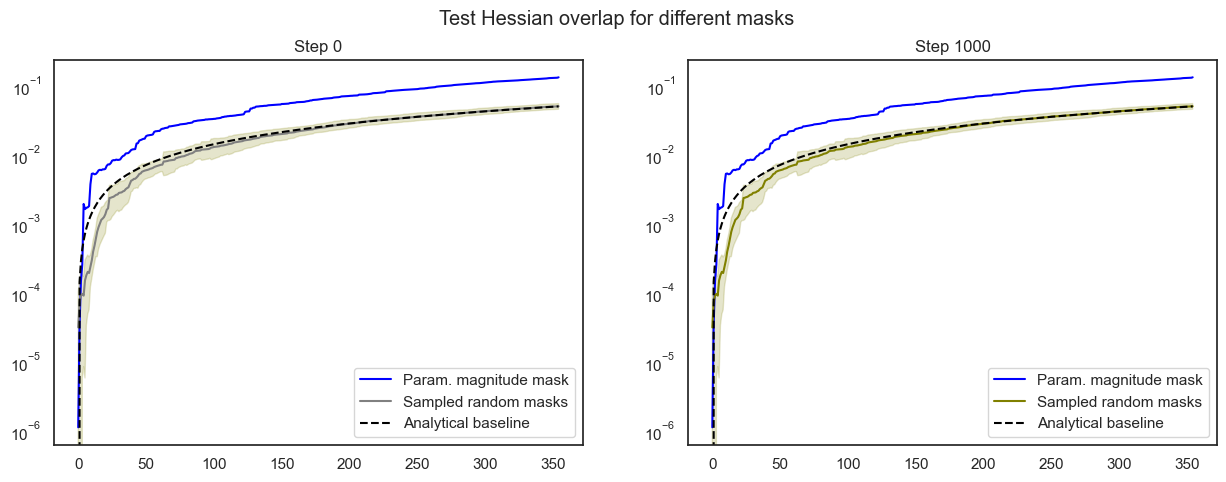

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
#
ax1.plot(mag_test0, color="blue", label="Param. magnitude mask")
ax1.plot(rm_test0, color="gray", label="Sampled random masks")
ax1.fill_between(list(range(len(rm_test0))), rm_test0-rsdt_test0, rm_test0+rsdt_test0, color="olive", alpha=0.2)
ax1.plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline")
ax1.set_yscale("log")
#
ax2.plot(mag_test1, color="blue", label="Param. magnitude mask")
ax2.plot(rm_test1, color="olive", label="Sampled random masks")
ax2.fill_between(list(range(len(rm_test1))), rm_test1-rsdt_test1, rm_test1+rsdt_test1, color="olive", alpha=0.2)
ax2.plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline")
ax2.set_yscale("log")
#
ax1.legend()
ax2.legend()
fig.suptitle("Test Hessian overlap for different masks")
ax1.set_title(f"Step {record_steps[0]}")
_ = ax2.set_title(f"Step {record_steps[-1]}")